In [1]:
import numpy as np
from imageio import imread
from skimage.transform import resize
from keras import Model
from keras.layers import Dense
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.applications.resnet_v2 import ResNet152V2 , preprocess_input
from keras.optimizers import Adam,SGD,RMSprop,Adadelta



In [5]:
data = np.empty((3000,96,96,3))
for i in range(1499):
  im = imread("/content/drive/MyDrive/Colab Notebooks/yeni/images/yes/y{:01d}.jpg".format(i+1))
  im = preprocess_input(im)
  im = resize(im,output_shape=(96,96,1))
  data[i] = im

for i in range(1499):
  im = imread("/content/drive/MyDrive/Colab Notebooks/yeni/images/no/no{:01d}.jpg".format(i+1))
  im = preprocess_input(im)
  im = resize(im,output_shape=(96,96,1))
  data[i+1500] = im

data.shape

(3000, 96, 96, 3)

In [6]:
import numpy as np
labels = np.empty(3000,dtype = int)
labels[:1500] = 1
labels[1500:] = 0
labels.shape

(3000,)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, shuffle =True)


print(f"X_train: {len(X_train)}")
print(f"y_train: {len(y_train)}")

print(f"X_test: {len(X_test)}")
print(f"y_test: {len(y_test)}")

X_train: 2400
y_train: 2400
X_test: 600
y_test: 600


In [9]:
def define_model(hp):
  base_model = ResNet152V2(weights = 'imagenet', include_top = False, input_shape = (96,96,3), pooling ="avg")
  predictions = Dense(2, activation = 'sigmoid')(base_model.output)
  head_model = Model(inputs = base_model.input, outputs = predictions)

  for layer in base_model.layers:
    layer.trainable = False

  optimizer = Adam(hp.Choice('learning_rate',values=[1e-3,1e-4]))
  head_model.compile(optimizer= hp.Choice('optimizer',values=['adam','sgd','adadelta','rmsprop']),
                   loss= "sparse_categorical_crossentropy",
                   metrics=['accuracy']
                   )  

  return head_model

In [10]:
!pip install keras-tuner
import keras_tuner
from keras_tuner.engine.hyperparameters import HyperParameters

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.9 MB/s eta 0:00:00


In [11]:
tuner = keras_tuner.RandomSearch(
    define_model,
    objective='val_accuracy',
    max_trials=8,
    executions_per_trial = 1,
    directory = "klasör",
    project_name="deneme6",
    overwrite = True
    )

234545216/234545216 [==============================] - 8s 0us/step


In [14]:
tuner.search(X_train, y_train,epochs=50,validation_split = 0.2)

Trial 8 Complete [00h 05m 35s]
val_accuracy: 0.6479166746139526

Best val_accuracy So Far: 0.9854166507720947
Total elapsed time: 00h 50m 47s


In [15]:
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)

{'learning_rate': 0.001, 'optimizer': 'adam'}


In [16]:
def built_model():
  base_model = ResNet152V2(weights = 'imagenet', include_top = False, input_shape = (96,96,3), pooling ="avg")
  predictions = Dense(2, activation = 'sigmoid')(base_model.output)
  head_model = Model(inputs = base_model.input, outputs = predictions)

  for layer in base_model.layers:
    layer.trainable = False

  optimizer = Adam(learning_rate = 0.001)
  head_model.compile(optimizer= optimizer,
                   loss= "sparse_categorical_crossentropy",
                   metrics=['accuracy']
                   )  

  return head_model

In [17]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn= built_model,epochs =50 ,batch_size=64,verbose=2 )

<ipython-input-17-b14f3010d4d2>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn= built_model,epochs =50 ,batch_size=64,verbose=2 )


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model,X_train,y_train,cv=3,scoring="accuracy")

Epoch 1/50
25/25 - 11s - loss: 1.3555 - accuracy: 0.5744 - 11s/epoch - 421ms/step
Epoch 2/50
25/25 - 2s - loss: 0.4477 - accuracy: 0.7944 - 2s/epoch - 91ms/step
Epoch 3/50
25/25 - 2s - loss: 0.2942 - accuracy: 0.8856 - 2s/epoch - 91ms/step
Epoch 4/50
25/25 - 2s - loss: 0.2267 - accuracy: 0.9137 - 2s/epoch - 91ms/step
Epoch 5/50
25/25 - 2s - loss: 0.1884 - accuracy: 0.9431 - 2s/epoch - 92ms/step
Epoch 6/50
25/25 - 2s - loss: 0.1592 - accuracy: 0.9538 - 2s/epoch - 91ms/step
Epoch 7/50
25/25 - 2s - loss: 0.1420 - accuracy: 0.9650 - 2s/epoch - 92ms/step
Epoch 8/50
25/25 - 2s - loss: 0.1307 - accuracy: 0.9619 - 2s/epoch - 92ms/step
Epoch 9/50
25/25 - 2s - loss: 0.1129 - accuracy: 0.9737 - 2s/epoch - 92ms/step
Epoch 10/50
25/25 - 2s - loss: 0.1021 - accuracy: 0.9787 - 2s/epoch - 93ms/step
Epoch 11/50
25/25 - 2s - loss: 0.0912 - accuracy: 0.9825 - 2s/epoch - 95ms/step
Epoch 12/50
25/25 - 2s - loss: 0.0845 - accuracy: 0.9831 - 2s/epoch - 93ms/step
Epoch 13/50
25/25 - 2s - loss: 0.0780 - accura

In [ ]:
print(f"1-Fold: {scores[0]}")
print(f"2-Fold: {scores[1]}")
print(f"3-Fold: {scores[2]}")
print()
print(f"ortalama accuracy değeri : {scores.mean()}")

1-Fold: 0.97375
2-Fold: 0.96875
3-Fold: 0.985

ortalama accuracy değeri : 0.9758333333333332


In [ ]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=1,mode="min",restore_best_weights=True)

In [ ]:
import time
t0 = time.time()

model = built_model()
result = model.fit(X_train,y_train,validation_split=0.2,epochs=100,batch_size=64, callbacks=[callback])
print("Training time:", time.time()-t0)

Epoch 1/100
30/30 [==============================] - 14s 225ms/step - loss: 0.7077 - accuracy: 0.7036 - val_loss: 0.4069 - val_accuracy: 0.8125
Epoch 2/100
30/30 [==============================] - 4s 133ms/step - loss: 0.2801 - accuracy: 0.8823 - val_loss: 0.2524 - val_accuracy: 0.9062
Epoch 3/100
30/30 [==============================] - 4s 133ms/step - loss: 0.2038 - accuracy: 0.9297 - val_loss: 0.2083 - val_accuracy: 0.9271
Epoch 4/100
30/30 [==============================] - 4s 133ms/step - loss: 0.1618 - accuracy: 0.9510 - val_loss: 0.1833 - val_accuracy: 0.9396
Epoch 5/100
30/30 [==============================] - 5s 152ms/step - loss: 0.1400 - accuracy: 0.9583 - val_loss: 0.1750 - val_accuracy: 0.9500
Epoch 6/100
30/30 [==============================] - 5s 153ms/step - loss: 0.1186 - accuracy: 0.9677 - val_loss: 0.1472 - val_accuracy: 0.9542
Epoch 7/100
30/30 [==============================] - 5s 153ms/step - loss: 0.1020 - accuracy: 0.9760 - val_loss: 0.1293 - val_accuracy: 0.964

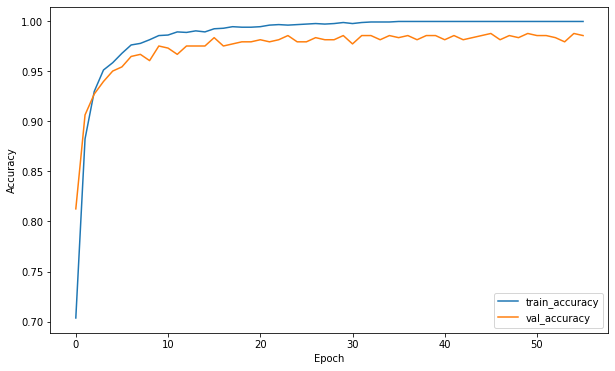

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Plot the the training loss
plt.plot(result.history["accuracy"], label="train_accuracy")

# Plot the the validation loss
plt.plot(result.history["val_accuracy"], label="val_accuracy")


# Name the x and y axises
plt.ylabel("Accuracy") 
plt.xlabel("Epoch")


# Put legend table
plt.legend()

# Show the plot
plt.show()

In [ ]:
import time
t0 = time.time()
degerlendirme = model.evaluate(X_test, y_test)
t1 = time.time()
elapsed = (t1-t0)/600
print(f"loss değeri : {degerlendirme[0]}")
print(f"accuracy değeri : {degerlendirme[1]}\n")

print("bir gözlemin test edilmesi: " + time.strftime("%H:%M:%S:{}".format(str(elapsed % 1)[15:])[:11], time.gmtime(elapsed))+ " milisaniye")





19/19 [==============================] - 1s 66ms/step - loss: 0.0853 - accuracy: 0.9783
loss değeri : 0.0853322446346283
accuracy değeri : 0.9783333539962769

bir gözlemin test edilmesi: 00:00:00:40 milisaniye


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
prediction1 = model.predict(X_test)
prediction = np.argmax(prediction1,axis=1)


19/19 [==============================] - 1s 64ms/step


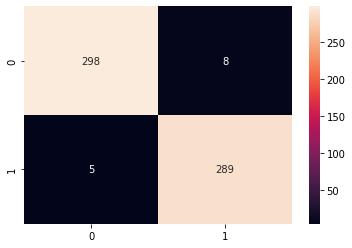

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_test, prediction)
f = sns.heatmap(cm, annot=True,fmt='d')

In [ ]:
from sklearn.metrics import classification_report

rapor = classification_report(y_test,prediction, labels = [0,1],target_names=["Tümörsüz","Tümörlü"])
print(rapor)

              precision    recall  f1-score   support

    Tümörsüz       0.98      0.97      0.98       306
     Tümörlü       0.97      0.98      0.98       294

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

